<a href="https://colab.research.google.com/github/DS-Jerry-in-Taiwan/Mnist-classifiaction/blob/main/Digit_Reconition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
---
Jerry Lee from Taiwan

- This is a digits recognition for minist dataset which try to build in different models

- Choose build model with keras API (Tensorflow backend) and sklearn
- Notebook remain following three main parts
  1. data preparation
    - download data from website
    - upzip file by gzip
    - decode file iindx foram
  2. data pre-process
    - data distribution
    - label smoothing

  3. model building
    - mult-class classification
  4. result comparing

- reference
  1. [mnist project done before](https://colab.research.google.com/drive/1jjLCLQA5Mh6Xf86VyeLlFKHGagVdMyeE?authuser=1)
  2. [kaggle 1](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
  3. [kaggle 2](https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers)
  4. [Deep learning course](https://www.coursera.org/learn/convolutional-neural-networks/)
  5. [The Story of MNIST database (YouTube Video)](https://www.youtube.com/watch?v=oKzNUGz21JM)


# Import Data
---
## download data from Yann LeCunn's Wbsite
  - [data explanation](http://yann.lecun.com/exdb/mnist/), [explanation from kaggle](https://www.kaggle.com/ngbolin/mnist-dataset-digit-recognizer)
  - [idx explanation](https://www.fon.hum.uva.nl/praat/manual/IDX_file_format.html)
  - 


In [ ]:
# !pip install py7zr
from sklearn.metrics import r2_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, roc_auc_score
import gzip
# import py7zr
import requests
import os
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from google.colab import drive ,files
import struct, pickle
from scipy.ndimage.interpolation import shift
import shutil
# import zipfile

In [ ]:
#Mount colab to gdrive
drive.mount('/content/drive')
#Change workdirection to proper folder 
os.chdir('/content/drive/MyDrive/adventure_time/mnist')
#Show the work direction
os.getcwd()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/adventure_time/mnist'

In [ ]:
#Define function to be used later
##
def fetch_via_request(url,fdir):
  with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(fdir, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)  

## extract gzip file
def un_zip(files,uncompress):
  with gzip.open(files,'rb') as f_in :
    with open(uncompress,'wb') as f_out :
      shutil.copyfileobj(f_in,f_out)
      print('%s uncompress to %s'%(files,uncompress))


## Show mnist data
def show_mnist(im,lb,idx):
  d = im[idx].reshape(28,28)
  plt.imshow(d, cmap='CMRmap',)
  # add grid
  plt.grid(b = 'on', ls= '--', alpha=0.8,color='white')
  # add title
  plt.title(f'label of {idx}-th digit = {lb[idx]:d}')
  # adjust x-y axis to make them equally
  plt.xticks(range(0,28,5),['%d'% x for x in range(0,28,5)])
  plt.tight_layout()


In [ ]:
web_path = "http://yann.lecun.com/exdb/mnist"
files = ['train-images-idx3-ubyte','train-labels-idx1-ubyte',
            't10k-images-idx3-ubyte','t10k-labels-idx1-ubyte']
url = [web_path+ "/" + x + '.gz'  for x in files]
output_fpath = [os.getcwd()+"/"+ x + '.gz' for x in files]
unzip_in = [x + '.gz' for x in files]

for i in range(len(files)):
  print(i)
  print("Download files:{}".format(files[i]))
  print("Zip files:{}".format(unzip_in[i]))
  # fetch_via_request(url[i],output_fpath[i])   
  un_zip(output_fpath[i],files[i])
  # with gzip.open(unzip_in[i],'rb') as f_in :
  #   with open(files[i],'wb') as f_out :
  #     shutil.copyfileobj(f_in,f_out)
  #     print('%s uncompress to %s'%(unzip_in[i],files[i]))                            

print('mnist data base fetched')


0
Download files:train-images-idx3-ubyte
Zip files:train-images-idx3-ubyte.gz
/content/drive/My Drive/adventure_time/mnist/train-images-idx3-ubyte.gz uncompress to train-images-idx3-ubyte
1
Download files:train-labels-idx1-ubyte
Zip files:train-labels-idx1-ubyte.gz
/content/drive/My Drive/adventure_time/mnist/train-labels-idx1-ubyte.gz uncompress to train-labels-idx1-ubyte
2
Download files:t10k-images-idx3-ubyte
Zip files:t10k-images-idx3-ubyte.gz
/content/drive/My Drive/adventure_time/mnist/t10k-images-idx3-ubyte.gz uncompress to t10k-images-idx3-ubyte
3
Download files:t10k-labels-idx1-ubyte
Zip files:t10k-labels-idx1-ubyte.gz
/content/drive/My Drive/adventure_time/mnist/t10k-labels-idx1-ubyte.gz uncompress to t10k-labels-idx1-ubyte
mnist data base fetched


In [ ]:
def read_idx(files):
  with open(files,'rb') as f:
    z, data_type, dims = struct.unpack('>HBB',f.read(4))
    if dims == 3:
      n = struct.unpack('>I',f.read(4))[0]#Why use read(4)??
      r = struct.unpack('>I',f.read(4))[0]
      c = struct.unpack('>I',f.read(4))[0]
      shape=(n,r,c)
    else:
      n = struct.unpack('>I',f.read(4))[0]
      shape=(n)

    return np.fromfile(f,dtype=np.dtype(np.uint8).newbyteorder('>'))

In [ ]:
# Read data
for i in range(len(files)):
  print('file:{}'.format(files[i]))
  if 'train' in files[i]:
    if 'images' in files[i]:
      print("it's train image")
      raw_train = read_idx(files[i])
      train_data = np.reshape(raw_train,(60000,28*28))
    else:
      print("it's train label")
      train_y = read_idx(files[i])
  else:
    if 'images' in files[i]:
      print("it's test image")
      raw_test = read_idx(files[i])
      test_data = np.reshape(raw_test,(10000,28*28))
    else:
      print("it's test label")
      test_y = read_idx(files[i])




file:train-images-idx3-ubyte
it's train image
file:train-labels-idx1-ubyte
it's train label
file:t10k-images-idx3-ubyte
it's test image
file:t10k-labels-idx1-ubyte
it's test label


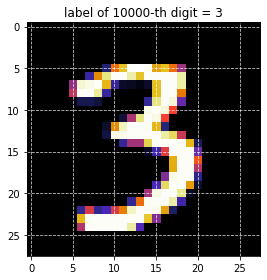

In [ ]:
#Display hand-written element in data
idx = 10000
show_mnist(train_data,train_y,idx)

## Data pre-process
---



### Data distribution
  - Visualize data distribution by [countlpot](https://seaborn.pydata.org/generated/seaborn.countplot.html)
  - To avoid bias causing by imbalance data
    - why imbalance is a problem
    - what kind of index to detect 
    - how to handle data with imbalance problem


Text(0.5, 1.0, 'Category countplot')

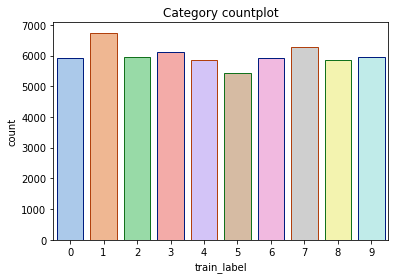

In [ ]:
cnt = pd.DataFrame()
cnt['train_label'] = train_y
x=sns.countplot(x = 'train_label',
       data = cnt,
       palette='pastel',
       edgecolor=sns.color_palette("dark", 3))

# for p in x.patches:
#     x=p.get_bbox().get_points()[:,0]
#     y=p.get_bbox().get_points()[1,1]
#     ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            # ha='center', va='bottom') # set the alignment of the text
plt.title('Category countplot')



### Label Smoothing
  - add noise to the 
  - to avoid overfiting
    - Why overfiting is probelm
    - what index to detect overfiting
    - how to fix overfiting problem

In [ ]:
#使用label smoothing 使資料不要出現過度擬合(overfitting)的狀況
fac = 0.99/255 #normalization:將資料限縮在 0~1 之間的權數

train_x = train_data * fac + 0.01 #lable smoothing:在normalization後增加白噪音(0.01)
test_x = test_data * fac + 0.01   #使資料較不會overfiting

In [ ]:
test_x

array([[0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       ...,
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01],
       [0.01, 0.01, 0.01, ..., 0.01, 0.01, 0.01]])

## Build Model
---
  - Build pipeline
  - model selection
    - [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
    - Visiualize the result to compare effectiveness between models
  - pick the best one

### Multi-class classification
  - Logistic regression
  - k-Nearest Neighbor
  - Multi layer Percetron
  - CNN

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
lr = LogisticRegression(max_iter = 500)
lr.fit(train_x,train_y)
y_hat_lr = lr.predict(test_x)

In [ ]:
print("\n-----------------------------------------")
print("train score: %.4f"%lr.score(train_x,train_y))
print("test score: %.4f"%lr.score(test_x,test_y))
print("\n-----------------------------------------")

#1-9的precesion跟record都會列印出來;accuracy則是取平均
rep = classification_report(test_y,y_hat_lr)
print(rep)



-----------------------------------------
train score: 0.9392
test score: 0.9257

-----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.93      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
%%time

#使用mlxtend畫confusion matrix：先用sklean計算confusion matrix然後在繪製confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.metrics import confusion_matrix

# 1.計算confusion matrix
mlx_cm = confusion_matrix(test_y,y_hat_lr)

# 2. plot confusion matrix
fig,ax=plot_cm3(conf_mat=mlx_cm,show_normed=True,#show_normed：顯示normalization的結果
                colorbar=True,figsize=(20,10))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

knn = KNeighborsClassifier(n_neighbors=3,algorithm="auto")
knn.fit(train_x,train_y)
y_hat_knn = knn.predict(test_x)
rep = classification_report(test_y,y_hat_knn)
print(rep)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.96      1.00      0.98      1135
           2       0.98      0.97      0.97      1032
           3       0.96      0.97      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [ ]:
%%time

#使用mlxtend畫confusion matrix：先用sklean計算confusion matrix然後在繪製confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.metrics import confusion_matrix

# 1.計算confusion matrix
mlx_cm = confusion_matrix(test_y,y_hat_lr)

# 2. plot confusion matrix
fig,ax=plot_cm3(conf_mat=mlx_cm,show_normed=True,#show_normed：顯示normalization的結果
                colorbar=True,figsize=(20,10))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#MLP(multi layer perceptron)
mlp = MLPClassifier(hidden_layer_sizes=128,
           max_iter=100,
           activation='tanh',
           solver='adam',
           tol=1E-4,
           random_state=0,
           learning_rate_init=0.005,#起始學習率
           shuffle=True,
           verbose=False,#是否在運算過程中列出訊息：False
           learning_rate='adaptive')
mlp.fit(train_x,train_y)
y_hat_mlp = mlp.predict(test_x)
rep = classification_report(test_y,y_hat_mlp)
print(rep)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.94      0.97      0.95      1010
           4       0.98      0.97      0.98       982
           5       0.98      0.95      0.96       892
           6       0.98      0.97      0.98       958
           7       0.98      0.95      0.97      1028
           8       0.95      0.97      0.96       974
           9       0.95      0.98      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



CPU times: user 72.1 ms, sys: 10.6 ms, total: 82.8 ms
Wall time: 104 ms


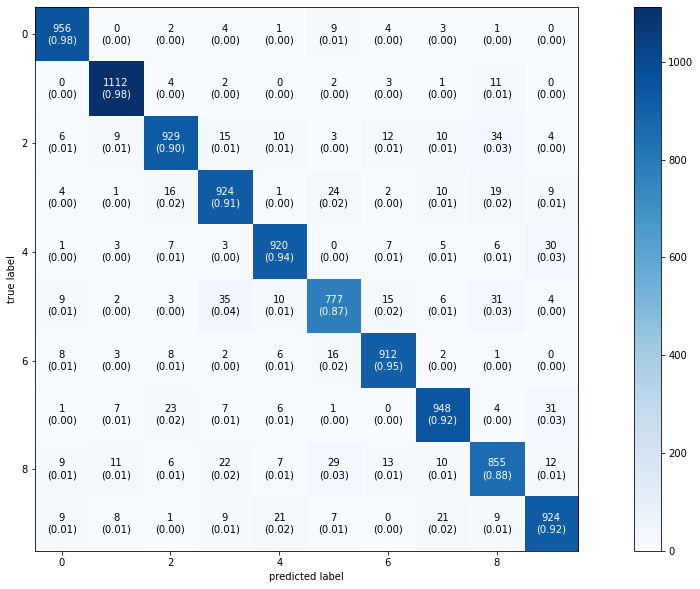

In [ ]:
%%time

#使用mlxtend畫confusion matrix：先用sklean計算confusion matrix然後在繪製confusion matrix plot
from mlxtend.plotting import plot_confusion_matrix as plot_cm3
from sklearn.metrics import confusion_matrix

# 1.計算confusion matrix
mlx_cm = confusion_matrix(test_y,y_hat_lr)

# 2. plot confusion matrix
fig,ax=plot_cm3(conf_mat=mlx_cm,show_normed=True,#show_normed：顯示normalization的結果
                colorbar=True,figsize=(20,10))

In [ ]:
#   try:
#     from google.colab import drive, files
#     in_colab = True
# except ModuleNotFoundError:
#     in_colab = False

# if in_colab:
#     home_dir = ''
#     drive.mount('/content/drive')
#     groot_dir = '/content/drive/MyDrive/adventure_time/'
# else:
#     from pathlib import Path
#     home_dir = str(Path.home())
#     groot_dir = home_dir + '/Google Drive/adventure_time/'

Mounted at /content/drive


### Binary classification
  - Percetron
  - SGD classification